# One dimensinal CAs and Genetic Algorithms Foundation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import collections
import math
from operator import itemgetter
from tqdm import tqdm

# Verificar pasta de trabalho

In [11]:
os.getcwd()

'C:\\Users\\diogo\\inteligenciaArtificial\\Inteligencia artificial\\Celular_Automata_V2'

## Terminologia usada neste notebook

termo | definição
------------ | -------------
autómato ou célula | Qualquer uma das entidades que formam parte de uma rede dinâmica em espaço/tempo
network | Conjunto de células (autómatos) de tamanho N
rule | representação do dicionario que contem todas as especificaçõs dos próximos estados possíveis para uma célular dependendo da sua configuração de vizinhanza local
rad | Número de vizinhos considerados por cada célula a cada lado 
nei | Vizinhança local de uma célula cujo tamanho e 2 * rad + 1
res | Variável auxiliar usada para calcular o estado da network em t+1

Adiciona os termos que faltam na tabela...

## Functions to compute CA dynamics

In [12]:

# this little vanilla-soft function computes the updating of a single time step.
# step_network takes a network configuration at time t, the rule we want to use 
# as a list of integers representing cell outputs in inverse lexicographic of the 
# local neighbourhoods, the corresponding rule radius and returns a list
# corresponding to the network configuration of the cells a t t+1
# this code is very 'beginners' like, you can optimise it

def step_network(network, rule, rad):
    res = [] 
    for i in range(len(network)) :
        offset_left = i - rad
        offset_right = (i + rad)
        sw=0
        network_copy = network       
        # case 1: when we have left neighbours on the right end of the network
        if offset_left < 0 :
            sw =1
            network_copy = np.roll(network, offset_left*(-1))
            nei = network_copy[0:2*rad+1] 
            lc = list(map(str,nei)) # convert neighbourhood into list of chars
            pos = int(''.join(lc), 2) # convert list of chars into joint string and convert that string (binary) to integer (decimal)
            res.append(rule[pos])
        # case 2: when we have right neighbours at the left end of the network
        if offset_right >= len(network) :
            sw=1
            start = ((2*rad)+1)*-1
            mv = -1*(offset_right-i)
            network_copy = np.roll(network, mv)
            nei = network_copy[start:]
            lc = list(map(str,nei))
            pos = int(''.join(lc), 2)
            res.append(rule[pos])
        # case 3: when all the neighbours are in the same section of the network
        if sw == 0:
            nei = network_copy[i-rad:i+rad+1]
            lc = list(map(str,nei))
            pos = int(''.join(lc), 2)
            res.append(rule[pos])
    return(res)

# And this, also vanilla-soft function computes the entire dynamics of m time steps
    
def runCA(net, rule, rad, m):
    i=1
    sp = []
    this = net
    while i < m:
        ts = step_network(this, rule, rad)
        #print(ts)
        sp.append(ts)
        this = ts
        i+=1
    return(sp) #Ex: [[0,1,0,0,1,0],[0,1,0,0,1,0],[0,1,0,0,1,0],...,[0,1,0,0,1,0]] 

### Now we can run and visualise CAs

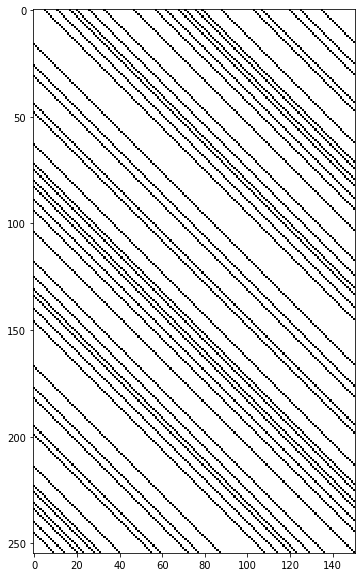

In [13]:
# rule representation
# convert to binary and pad left with zeroes
# reverse so that least significant neighbourhood is first

# setting the CA rule
rule = 110 #base 10 rule representation
r = 1 
n = (2*r)+1
s = 2
rule_list =  list(map(int, list(np.binary_repr(rule,n**2))))
rule_list.reverse() #we need to reverse it so that we can take advantage of saying that the element
                    #in position 0 of the list corresponds to the neighbourhood of all zeros
rule_list = [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
# Now we setting the initial configuration

network_size = 151 # say you want 151 automata in your 1D CA
network = np.random.randint(0, s, network_size) # make your automata start with random choice (1 or 0)

#%%timeit n=100
x = runCA(network, rule_list, 1, len(rule_list)*2)
nx = np.array(x)
nx.astype(float)
fig = plt.figure(figsize=(10,10))
plt.imshow(nx, cmap='Greys');
plt.show()

network = tamanho de 100

Correr o CA significa:
Aplicar a regra 2* o tamanho da network


## Support Functions for the Genetic Algorithm

Do not try to run the code below because it is incomplete. You need to complete T1, T2, T3 and T4 indicated in the comments before you can continue to the next block. Estimated time to complete these four code completions 15-25 minutes.

In [14]:

# Parameters

population = [] # here you will add random CA rules in rad = 3 (the size of which has to be 128)
training_set_size = 10 # this is the number of network examples I will use to compute rule fitness for majority classification
population_size = 20 # this is the population size (P)
elite_size = 5 # number of CA rules considered for the Elite

rad = 3 # the rad is 3, we know that this is necessary for majority classification
s=2 # each cell can have one of two states
n = (2*rad)+1 # the size of the neighbourhood of a cell
network_size = 91 # say you want 91 cells in your 1D CA
ca_steps = 182 # the number of time steps to run CAs for when we are computing fitness

mutation_rate = 0.02 # you can vary this
cross_over_points = 1 # you can vary this

# this code allows you to produce a random rule given number of states and size of local neigbourhood
def random_rule(s,n):
    rule_size = s**n
    rule_space = s**rule_size
    random_rule = random.getrandbits(rule_size)
    rule_list =  list(map(int, list(np.binary_repr(random_rule,rule_size))))
    return rule_list #Ex: [0,1,1,0,0,1]

def generate_training_set(training_set_size, s, network_size):
    training_set = []
    for i in range(training_set_size):
        t = np.random.randint(0, s, network_size) # make your automata start with random choice (1 or 0)
        training_set.append(list(t))
    return training_set #Ex:[[0,1,0,0,1],[0,1,0,0,1],[0,1,0,0,1]]

# this code allows you to create a set of network examples to test the fitness of CA rules in your populations
training_set = []
for i in range(training_set_size):
    t = np.random.randint(0, s, network_size) # make your automata start with random choice (1 or 0)
    training_set.append(list(t))

# this code allows you to create a set of CA rules to form your populations
population = []
for i in range(population_size):
    r = random_rule(2,7)
    population.append([r, 0])

def compute_fitness(individual, training_set, r, steps):
    performance_list =[]

    for example in training_set:
            
            #Count 0 and 1 at the start
            counter1 = collections.Counter(individual)
            count_zeroes = counter1[0]
            count_ones = counter1[1]
            
            #Get majority at the start
            if count_zeroes > count_ones:
                majority = 0
            else:
                majority = 1
                
            #Run celular automata for a certain individual
            ca_dynamics = runCA(example, individual, r, steps) #Ex:[[0,0,1,0,1],[0,0,1,0,1],[0,0,1,0,1],[0,0,1,0,1]...,[0,0,1,0,1]]
            
            #Count 0 and 1 at the end
            counter2 = collections.Counter(ca_dynamics[len(ca_dynamics)-1])
            keys = list(counter2.keys())
            if majority in keys:
                performance = counter2[majority] / len(ca_dynamics[len(ca_dynamics)-1])
            else:
                performance = 0
            
            #Append performance to the list
            performance_list.append(performance)
    return sum(performance_list)/len(performance_list) # remember that fitness is the average performance over the examples
        
        
    

### Test generation of single random CA rule and computation of majority classification fitness

In [20]:
my_rule = random_rule(2,7)
compute_fitness(my_rule, training_set, rad, ca_steps)

0.48571428571428565

## Complete the rest of the functions for the Genetic Algorithm
Now work on the remaining GA functions. Estimated time to completion 2-4 hours

In [2]:
def cross_over(parent_1, parent_2, points):
    
    #Indices possiveis para crossover
    indexOptions = list(range(1,len(parent_1)-1))
    
    #Escolhemos aleatoriamente os crossover points
    crossOverPoints = sorted(random.sample(indexOptions, k=points) + [0,len(parent_1)]) #[0,2,4,6]
    children = [[],[]]
    for count in range(len(crossOverPoints)-1):
        if count % 2:
            children[0] += parent_1[crossOverPoints[count]:crossOverPoints[count+1]]
            children[1] += parent_2[crossOverPoints[count]:crossOverPoints[count+1]]
        else:
            children[1] += parent_1[crossOverPoints[count]:crossOverPoints[count+1]]
            children[0] += parent_2[crossOverPoints[count]:crossOverPoints[count+1]]
    return children
    
def mutation(child, mut_rate):
    states = [0,1]
    child = [ i if mut_rate < random.random() else random.choice(removeArrayElement(states,i)) for i in child]
    return child
    
def do_generation(population, training_set, rad, ca_steps):
    populationFitness = [] #Ex: [(rule,fit),(rul,fit)...] 
    for individual in population:
            populationFitness.append((individual,compute_fitness(individual, training_set, rad, ca_steps)))  
    return sorted(populationFitness,key=itemgetter(1), reverse = True)
    
def next_generation(populationFitness,points,mut_rate):
    eliteSize = 5
    elite = [i[0] for i in populationFitness[:eliteSize]]
    newGeneration = elite 
    
    while  len(newGeneration) < len(populationFitness):
        parents = random.sample(elite, k=2) #Ex:[[0,0,1,0,1],[0,0,0,1,0]]
        children = cross_over(parents[0],parents[1], points)
        for child in children:
            if(len(newGeneration) < len(populationFitness)):
                newGeneration.append(mutation(child,mut_rate))    
                
    return newGeneration
    
def removeArrayElement(array,element):
    a = array.copy()
    a.remove(element)
    return a

def run_genetic_algorithm(rad,s,population_size,network_size,training_set_size,elite_size,mut_rate,points):
    
    n = (2*rad)+1
    ruleSize = int(math.pow(s,n))
    steps = network_size * 2
    population = [random_rule(s,n) for i in range(population_size)] #Ex: [r1,r2,r3,r4]

    for i in range(50):
        
        training_set = generate_training_set(training_set_size, s, network_size)
        populationFitness = do_generation(population, training_set, rad, steps)
        print('Generation: ', i)
        print('Best fit: ', populationFitness[0][1])
        if populationFitness[0][1] > 0.95:
            print(populationFitness[0][0])
        population = next_generation(populationFitness,points,mut_rate)

# Majority Problem Code

## Variaveis costumizaveis

termo | definição
------------ | -------------
rad | Numero de vizinhos considerados por cada célula a cada lado
s | Numero de estados que uma celula pode ter
population_size | Quantas rules vão haver numa população
network_size | tamanho do automato (de uma dimensão)
training_set_size | Numero de automatos para computar o fit de cada rule 
elite_size | Tamanho da elite de cada geração
mut_rate | Probabilidade de mutação para os filhos
points | Numero de crossover points para a criação de filhos


In [43]:
rad = 3
s = 2
population_size = 20
network_size = 50
training_set_size = 20
elite_size = 5
mut_rate = 0.02
points = 2

run_genetic_algorithm(rad,s,population_size,network_size,training_set_size,elite_size,mut_rate,points)

Generation:  0
Best fit:  0.608
Generation:  1
Best fit:  0.6369999999999999
Generation:  2
Best fit:  0.9349999999999999
Generation:  3
Best fit:  0.932
Generation:  4
Best fit:  1.0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0]
Generation:  5
Best fit:  1.0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0]


KeyboardInterrupt: 

In [84]:
def mutation(child, mut_rate):
    states = [0,1]
    child = [ i if mut_rate < random.random() else random.choice(removeArrayElement(states,i)) for i in child]
    return child

def removeArrayElement(array,element):
    a = array.copy()
    a.remove(element)
    return a
ng =[]
children = [[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0]]
ng.append([mutation(child,0.5) for child in children ])

print(ng)
print(children)

[[[0, 0, 1, 1, 0, 0, 1, 1], [0, 1, 1, 1, 0, 0, 1, 0]]]
[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]]


In [92]:
def random_rule(s,n):
    rule_size = s**n
    rule_space = s**rule_size
    random_rule = random.getrandbits(rule_size)
    rule_list =  list(map(int, list(np.binary_repr(random_rule,rule_size))))
    return rule_list

s = 2
n = (2*r)+1
population_size = 2

population = [random_rule(s,n) for i in range(population_size)]
print (population)

[[1, 1, 1, 1, 0, 0, 1, 0], [0, 1, 0, 1, 0, 0, 0, 0]]


In [95]:
def generate_training_set(training_set_size, s, network_size):
    training_set = []
    for i in range(training_set_size):
        t = np.random.randint(0, s, network_size) # make your automata start with random choice (1 or 0)
        training_set.append(list(t))
    return training_set

In [96]:
a = generate_training_set(2, 2, 5)
print(a)

[[0, 1, 1, 1, 1], [1, 1, 0, 0, 0]]


In [194]:
generate_training_set(5, s, 20)

[[1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0],
 [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1],
 [1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1]]

In [ ]:
def do_generation(population, training_set):
    # population: conjunto de CA rules
    # training_set: conjunto de exemplos para testar CA rules
    pop =[] 
    for individual in population:
        performance_list = []
        for example in training_set:
            count_zeroes = np.count_nonzero(example == 0)
            count_ones = np.count_nonzero(example == 1)
            if count_zeroes > count_ones:
                majority = 0
            else:
                majority = 1
            ca_dynamics = runCA(example, individual[0], rad, ca_steps)
            performance = ca_dynamics[-1].count(majority)/len(ca_dynamics[-1])
            performance_list.append(performance)
        fitness = sum(performance_list)/len(performance_list) 
        pop.append([individual, fitness])
    return sorted(pop, key=lambda x: x[1], reverse=True)